# NSL Notebook 07

In these exercises, we want to evolve a molecolar dynamic simulation (approximately the same Argon simulation of **Exercise 04**) not using a deterministic algo such as **Verlet algo**, but using **Monte Carlo**

So the key idea, is to exploit what we learned from **Metropolis algo** to evolve a many particles system using **Boltzmann probability**. The main hypothesis behind this approach is that the system can be approximate to a canonical ensemble.

In [1]:
from default import *

## Exercise 07.1

First of all we want to check some standard simulation parameters (e.g. the block size $L$) which were almost always chosen without justification.

So I run a complete simulation, using $5*10^5$ metropolis steps, and store all the $P$ and $V=U/N$ results inside these distinct files, for each state of matter:

* `P-$state.out`


* `V-$state.out`

So no blocking method has been used, for this test part. Only pure output results from the simulation. 

Clarification: I have been able to bypass blocking method part and output the results with the same `blockingMethod` function inside the class `MCMD` thanks to boolean flags that I add to it.\
In practice for this first run of tests, I change line 45 of `main.cpp`:

```cpp
md.blockingMethod(500,     // nblk, no matter here
                  true,    // write *.out
                  false,   // bypass g(r) computation
                  false);  // bypass other thermo-vars computation
```

### Exercise 07.1.1

With `*.out`, above, we would like to ensure that after a certain number of steps, the thermodynamic variables (so $P$ and $V$ in this case) become unrelated temporally.

Below I plot the first $1000$ time steps for each auto-correlation function and for each state of matter, computed using `correlation.cpp` source. As we can se all the time correlations drop after a few time steps, so we can safely say that using blocking method for a $L>250$ we populate each block with uncorrelated entries.

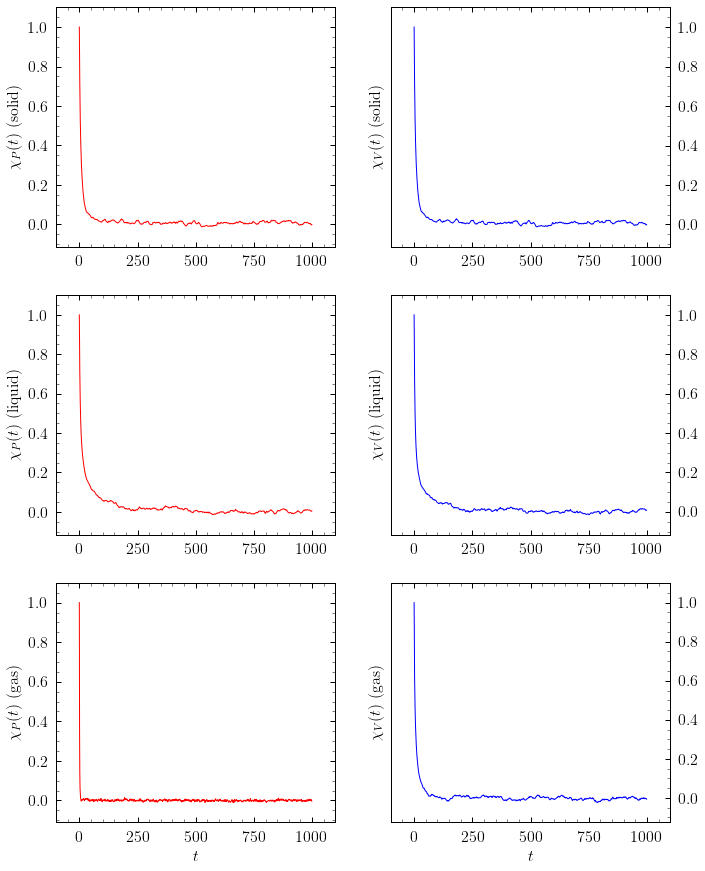

In [21]:
# load data
for state in states:
    df[state] = dict()
    for v in vv:
        df[state][v] = pd.read_csv(f"ac-{v}-{state}-head.out", 
                                   header=None, 
                                   names=['ac'])[:1000]

fig, ax = plt.subplots(3, 2, figsize=(11,15));
        
# reshape axes
ax = np.asarray(ax)
ax.shape = (1,6)
ax = ax[0]

ix=0
for state in states:
    for v in vv:
        df[state][v]['ac'].plot.line(c=next(cc), ax=ax[ix])
        ax[ix].yaxis.tick_right() if (ix+1) % 2 == 0 else 0
        ax[ix].set_ylabel(f"$\\chi_{v}(t)$ ({state})")
        ix += 1
        
ax[4].set_xlabel("$t$");
ax[5].set_xlabel("$t$");

### Exercise 07.1.2

With the same `*.out`, above, we would like to check, more precisely, the correct block size $L$ for each block when computing the blocking method. So, using a python script `data-blocking.py`, I data-blocked, for each thermodynamic vars ($P$ and $V$) and for each state of matter, using:

$$L = [10,\,25,\,50,\,100,\,250,\,500,\,1000,\,2500,\,5000,\,10000]\quad \text{with}\quad L=M/N$$

and save inside a file named `$var-$state-blk-evo.csv` the last average and its corresponding uncertainty. Theoretically should exist a $L$ limit value after which the uncertainties on final average after blocking method reach a plateau, and so rise again $L$ shouldn't improve the final result.

This mean your blocking method reach the best performance using right choice of blocks $N$ or block size per block $L$, for a total of $M$ entries.

Looking at the results below, it's clear enough, for solid and liquid state, that the correct value of $L$ for $M=5*10^5$ should be around $1000$, so $N=500$ blocks. For gas state, instead, there is a little stabilization about $1000$ but then again a rise.

Clarification: for each plot below, the y-axis doesn't show simple the trend of errors for each $L$ value, but the percentuage change between consecutive errors for each $L$.

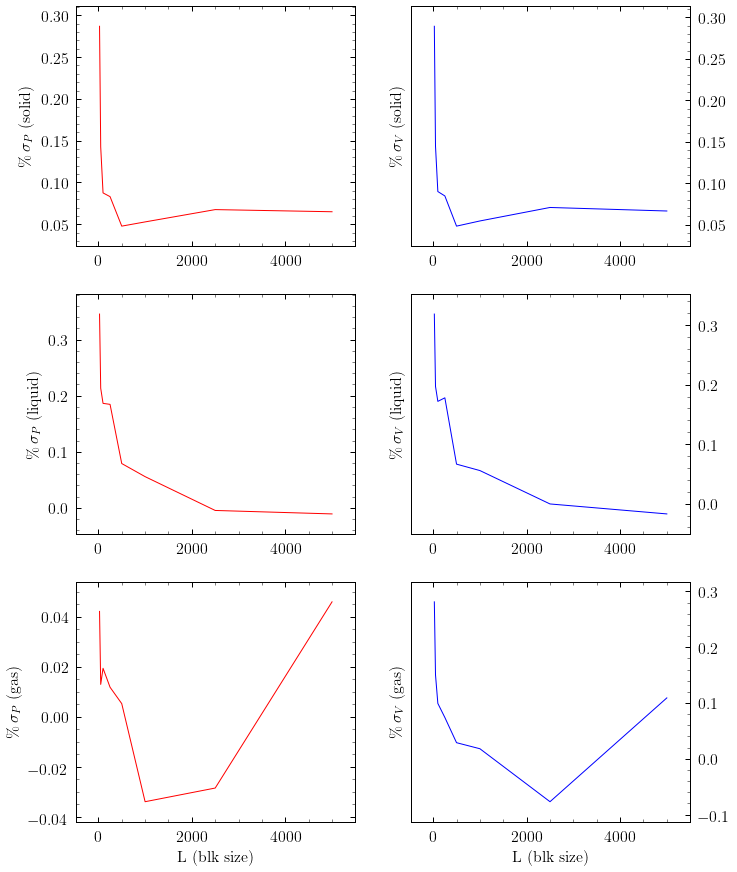

In [11]:
# load data
for state in states:
    df[state] = dict()
    for v in vv:
        df[state][v] = pd.read_csv(f"{v}-{state}-blk-evo.csv", 
                                   header=None, 
                                   sep=',', 
                                   names=[v,'e'])[:-1]

fig, ax = plt.subplots(3, 2, figsize=(11,15));

# reshape axes
ax = np.asarray(ax)
ax.shape = (1,6)
ax = ax[0]

L = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000]

ix=0
for state in states:
    for v in vv:
        ax[ix].plot(L[1:], df[state][v]['e'].pct_change()[1:], c=next(cc))
        ax[ix].yaxis.tick_right() if (ix+1) % 2 == 0 else 0
        ax[ix].set_ylabel(f"$\%\,\\sigma_{v}$ ({state})")
        ix += 1
        
ax[4].set_xlabel("L (blk size)");
ax[5].set_xlabel("L (blk size)");

## Exercise 07.4

Here start the real simulation part, after the tests above.

First of all the equilibration part, to reach a stable configuration (particle positions) before start.

Below I plotted different slice, of the total $5*10^4$ steps used for the equilibration, of the thermodynamic variables ($P$ and $V$) for each state of matter. As in the **Exercise 04** the gas doesn't show a clean equilibration behaviour, instead for solid and liquid states the thermodynamic vars oscillate around a costant value after less than $200$ steps.

By the way, for safety, and for semplicity, for all the state of matter, I start the "real simulation" from the configuration saved after the equilibration for all steps computed, so $5*10^4$

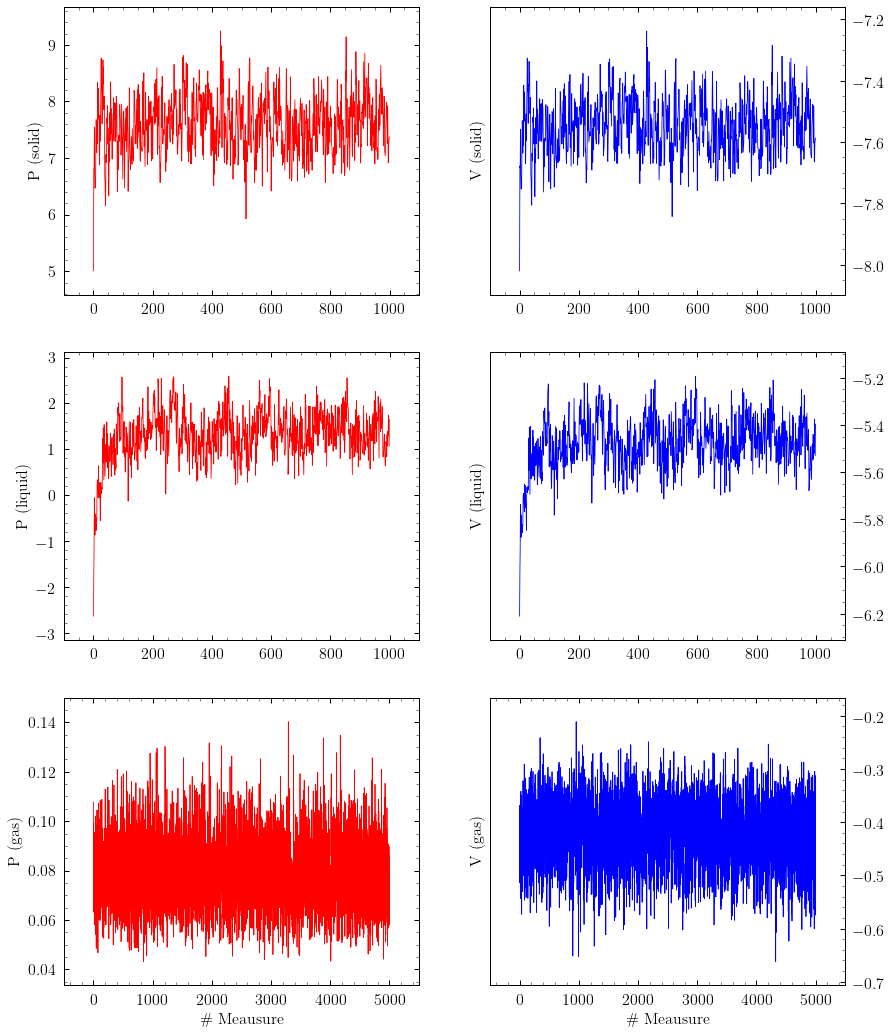

In [2]:
# load equilibrium oscillation
for state in states:
    df[state] = dict()
    dfa = pd.read_csv(f"th-{state}.tsv", 
                      header=None, 
                      sep='\t', 
                      names=['P', 'V'])
    for v in vv:
         df[state][v] = dfa[v]
            
for v in vv:
    df["solid"][v] = df["solid"][v][:1000]
    df["liquid"][v] = df["liquid"][v][:1000]
    df["gas"][v] = df["gas"][v][:5000]
        
fig, ax = plt.subplots(3, 2, figsize=(14,18));

# reshape axes
ax = np.asarray(ax)
ax.shape = (1,6)
ax = ax[0]

ix=0
for state in states:
    for v in vv:
        df[state][v].plot.line(c=next(cc), lw=0.8, ax=ax[ix]);
        ax[ix].yaxis.tick_right() if (ix+1) % 2 == 0 else 0
        ax[ix].set_ylabel(f"{v} ({state})");
        ix += 1
    
ax[4].set_xlabel("\# Meausure");
ax[5].set_xlabel("\# Meausure");

### Exercise 07.4.1

**Additional feauture**

Together with $V$ and $P$ have been calculated, for each state of matter, the radial distribution functions $g(r)$ with $r=[0,\,L/2]$. The idea to compute the $g(r)$ is to:

* divide the range $r=[0,\,L/2]$ into sub-ranges (each wide $dr$)
* count at every MC steps how many particles are within a distance $r+dr$
* normalize by the quantity $\rho N \Delta V(r)$
* blocking method in the end

To check the $g(r)$ results computed using `MCMD` class, this $g(r)$ algo has been added also to the `MD` class, to make a comparison.

Clarification: for both the class, the $g(r)$ computation was put inside the `blockingMethod` function, and it can be activated (independently from the other thermodynamic blocking method computation) using a boolean flag. Here an example from `main.cpp`:

```cpp

md.blockingMethod(500,    // nblk, number of blocks
                  false,  // no write *.out
                  true,   // compute g(r)
                  true);  // bypass other thermo-vars computation 
```

Clarification: $g(r)$ using **Metropolis algo**, so **Exercise 07** have been computed using $M=5*10^5$ steps, $N=500$ blocks, $L=1000$ block size, as decided in the previous exercise, together with the computation of blocking method for the other thermodynamic variables. \
Instead $g(r)$ using **Verlet algo**, not to perform the **Exercise 04** totally, have been computed adding the boolean flags (`false`,`true`,`true`) and using the original $M=10^5$ steps, $N=100$ blocks.

Below the results for $g(r)$ using **Verlet algo** or **Metropolis algo**, so `MCMD` class or `MD` class, for each state of matter. The results coincide.

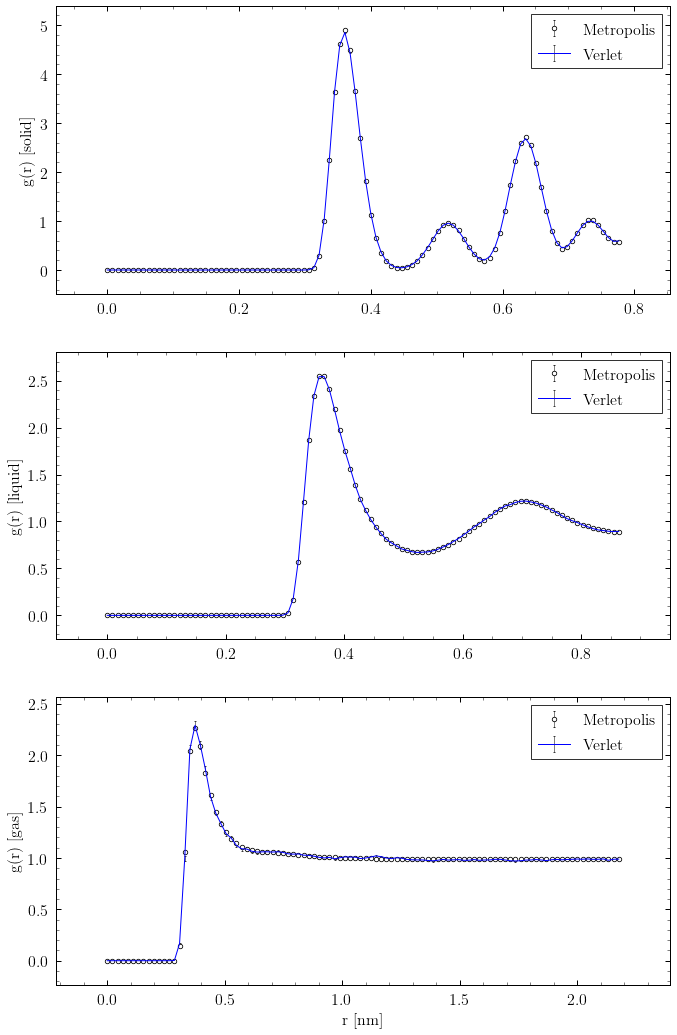

In [22]:
df = dict()
dft = dict()
SI = 0.34 # \sigma nm

# load g(r) data
for state in states:
    df[state] = pd.read_csv(f"gr-{state}-blk.csv", 
                            header=None, 
                            names=['r','v','e'])
    dft[state] = pd.read_csv(f"gr-{state}-verlet-blk.csv", 
                             header=None, 
                             names=['r','v','e'])
    
fig, ax = plt.subplots(3, 1, figsize=(11,18));    

for ix, state in enumerate(states):
    ax[ix].errorbar(df[state]['r']*SI, 
                    df[state]['v'], 
                    yerr=df[state]['e'], 
                    ls='', 
                    ecolor='gray', 
                    marker='.', 
                    ms=9, mfc='w', 
                    mec='k', 
                    mew=0.8, 
                    capthick=0.1, 
                    label='Metropolis')
    ax[ix].errorbar(dft[state]['r']*SI, 
                    dft[state]['v'], 
                    yerr=dft[state]['e'], 
                    c='b', 
                    ecolor='gray', 
                    marker=None, 
                    capthick=0.7, 
                    label='Verlet')
    ax[ix].set_ylabel(f'g(r) [{state}]', fontsize='medium')
    ax[ix].legend();
    
ax[2].set_xlabel('r [nm]', fontsize='medium');

### Excercise 07.4.2

Below the results of blocking method $M=5*10^5$, $N=500$, for $V$ and $P$ in S.I., for each state of matter, after the $5*10^4$ equilibration steps.

In [23]:
df = dict()
ee = 120 * 1.3806488e-23  # J energy
SI = {'V': ee*((1.602176565e-19)**-1)*(10**3), 'P': ee/(0.34e-9)**3}

# load P and V data
for state in states:
    df[state] = dict()
    for v in vv:
        df[state][v] = pd.read_csv(f"{v}-{state}-blk.csv", 
                                   header=None, 
                                   names=['v','e'])
        df[state][v] = df[state][v]*SI[v]

### Solid Argon

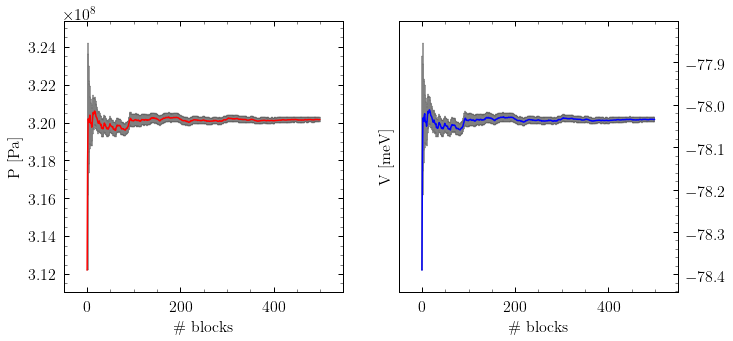

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(11,5));

ax = np.asarray(ax)
ax.shape = (1,2)
ax = ax[0]

for ix, v in enumerate(vv):
    df["solid"][v]['v'].plot.line(yerr=df["solid"][v]['e'], 
                                  color=next(cc), 
                                  lw=1.5, 
                                  ecolor='gray', 
                                  capthick=0.1, 
                                  ax=ax[ix]);
    ax[ix].set_ylabel(f"{v} [Pa]") if (ix == 0) else ax[ix].set_ylabel(f"{v}  [meV]")
    ax[ix].yaxis.tick_right() if (ix == 1 or ix == 3) else 0
    ax[ix].set_xlabel('\# blocks')

### Liquid Argon

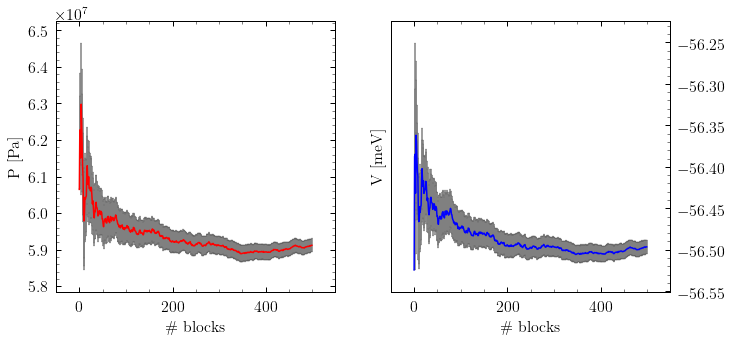

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(11,5));

ax = np.asarray(ax)
ax.shape = (1,2)
ax = ax[0]

for ix, v in enumerate(vv):
    df["liquid"][v]['v'].plot.line(yerr=df["liquid"][v]['e'], 
                                   color=next(cc), 
                                   lw=1.5, ecolor='gray', 
                                   capthick=0.1, 
                                   ax=ax[ix]);
    ax[ix].set_ylabel(f"{v} [Pa]") if (ix == 0) else ax[ix].set_ylabel(f"{v}  [meV]")
    ax[ix].yaxis.tick_right() if (ix == 1 or ix == 3) else 0
    ax[ix].set_xlabel('\# blocks')

### Gas Argon

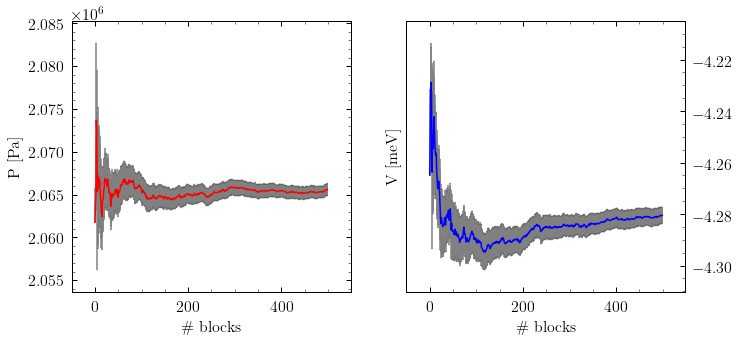

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(11,5));

ax = np.asarray(ax)
ax.shape = (1,2)
ax = ax[0]

for ix, v in enumerate(vv):
    df["gas"][v]['v'].plot.line(yerr=df["gas"][v]['e'], 
                                color=next(cc), 
                                lw=1.5, 
                                ecolor='gray', 
                                capthick=0.1, 
                                ax=ax[ix]);
    ax[ix].set_ylabel(f"{v} [Pa]") if (ix == 0) else ax[ix].set_ylabel(f"{v}  [meV]")
    ax[ix].yaxis.tick_right() if (ix == 1 or ix == 3) else 0
    ax[ix].set_xlabel('\# blocks')

ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))